In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# Read data from CSV files

train= pd.read_csv('Housepricesdata/train.csv', index_col = 'Id')
test = pd.read_csv('Housepricesdata/test.csv', index_col= 'Id')

In [52]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [53]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Data Processing

Documentation for the Ames Housing Data indicates that there are outliers present in the training data

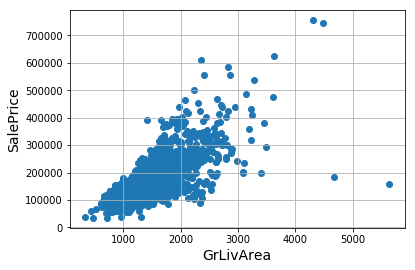

In [56]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=14)
plt.xlabel('GrLivArea', fontsize=14)
plt.grid(True)
plt.show()

In [57]:
# The document recommands removing any houses with more than 4000 square feet from the data set
# Dropping the outliers

train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

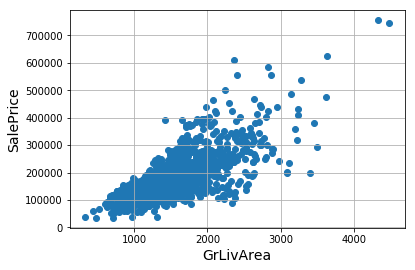

In [58]:
# Confirming the outlier are removed

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=14)
plt.xlabel('GrLivArea', fontsize=14)
plt.grid(True)
plt.show()

In [59]:
# Outlier removal is not safe! so make sure outlier removal is justified and does not affect the model.
# There may be other outlier in the rest of the data, but removing them may affect the model.
# and lead to flawed models if similar outlier are present in test data as well
# Hence the outliers are handled in the models to make them robust. 

Sale Price is the variable we need to predict, so lets do some analysis on theSalePrice. 

In [60]:
# A lot of kernels talk about the normalising the dependent variable to improve the results. 
# Therefore we are going to normalise the SalePrice

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


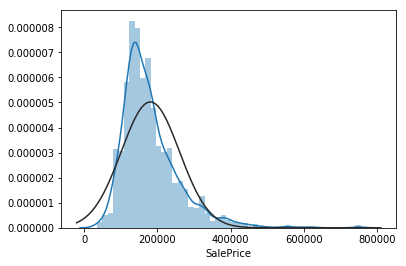

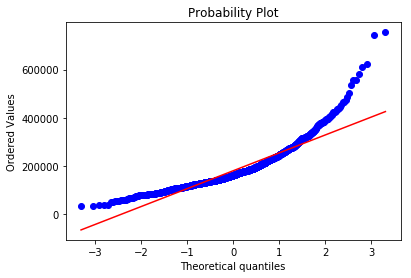

In [71]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [72]:
# This is definately not normal, as the data is right skewed. I'm applying log transformation to see what happenes

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


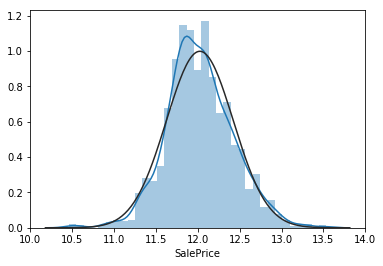

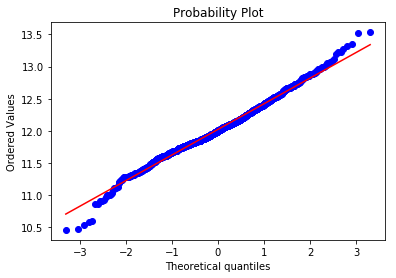

In [73]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [74]:
# A much better fit!!

Feature Engineering - Take care of missing data

In [77]:
# Its easier to concatinate training and test data to perform feature engineering. 
trainrows = train.shape[0]

In [78]:
trainrows

1458

In [79]:
testrows = test.shape[0]

In [80]:
testrows

1459

In [81]:
y_train = train.SalePrice.values

In [82]:
y_train

array([12.24769432, 12.10901093, 12.31716669, ..., 12.49312952,
       11.86446223, 11.90158345])

In [85]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)

In [86]:
all_data.shape

(2917, 80)

In [87]:
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [88]:
all_data.shape

(2917, 79)

Missing Data

In [91]:
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100

In [95]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806
